# The Impact of Age, Resting Blood Pressure, and Heart Rate on the Presence of Heart Disease

### DSCI 100 004 | Group 21
**By Leia Chen, Qianxue Wang, Rachel Ho, and Emily Shiu**

### Introduction:

The prevalence and impact of heart disease highlight why it's a big concern for everyone. Heart disease can affect people of all ages and backgrounds, making it a serious health issue that needs our careful attention. This concern is important because it can affect not just our own health but also the well-being of the people we care about. Ruan et al. (2018) found that cardiovascular disease (CVD), also known as heart disease, was the leading cause of global deaths, with about 17.9 million people passing away from it in 2015. Their research also predicts a concerning increase, suggesting that more than 22.2 million people could die from CVD every year by 2030 (Ruan et al., 2018). Understanding the risks and symptoms of heart disease is important for creating a healthier society, as it is a common condition that can be life-threatening. Heart disease includes various conditions, often connected to factors such as high blood pressure, elevated blood sugar levels, and various lifestyle choices, including smoking and alcohol drinking. Researching heart disease is a big focus in life sciences because it's important for healthcare professionals to quickly and correctly diagnose patients with this condition and provide appropriate treatment. So, collecting detailed and correct information about the different factors related to heart disease from patients who were diagnosed before is really important for improving healthcare.

Our main goal for this project is to analyze data gathered from people who have or don't have heart disease. We'll use the information about their different health aspects to answer this question: **Can age, resting blood pressure, and heart rate accurately predict the presence of heart disease?** 

The decision to analyze these variables for accurately predicting heart disease in patients came from creating several scatter plots during preliminary exploratory data analysis. These graphs featured multiple variables from the dataset we'll discuss shortly, plotted against each other, with coloured points indicating the presence of heart disease. We identified age, resting blood pressure, and maximum heart rate as the variables with the strongest relationship to the presence of heart disease.  Additionally, numerous studies have confirmed that these factors indeed influence the presence of heart disease in individuals. According to Rodgers et al. (2019), "Age is a significant independent risk factor for CVD, since it is associated with an increased likelihood of development of any number of other additional cardiac risk factors, including obesity and diabetes." In line with this, the Centers for Disease Control and Prevention (2022) emphasize, "High blood pressure is a leading cause of heart disease and stroke because it damages the lining of the arteries, making them more susceptible to the buildup of plaque, which narrows the arteries leading to the heart and brain." Therefore, we decided to use these variables for our data analysis. These variables are useful because they show a distinct trend between patients with and without heart disease.

The dataset we'll use to answer our question is the **Heart Disease Dataset** uploaded by David Lapp on the Kaggle website: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset/. This dataset, which was gathered in 1988, comprises four databases: Cleveland, Hungary, Switzerland, and Long Beach V. The dataset contains the following attributes:

1. age in years
2. sex (1 = male; 0 = female)
3. chest pain type (4 values)
4. resting blood pressure (in mm Hg on admission to the hospital)
5. serum cholesterol in mg/dl 
6. fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7. resting electrocardiographic results (values 0,1,2)
8. maximum heart rate achieved
9. exercise induced angina (1 = yes; 0 = no)
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
12. number of major vessels (0-3) coloured  by fluoroscopy
13. thal: 0 = normal; 1 = fixed defect; 2 = reversible defect

The "target" field refers to the presence of heart disease in the patient. It is integer valued 0 = no disease and 1 = disease.

### Methods:

By analyzing a patient's age, resting blood pressure, and maximum heart rate achieved and comparing them to the patterns we've observed regarding these variables and heart disease, we want to find out if this makes it easier and faster to know if they have heart disease or not. We avoid using variables that don't show a strong relationship, like cholesterol, as we expect that they would make it harder to accurately predict whether someone has heart disease or not. The columns from the selected dataset that we will be utilizing include age in years, resting blood pressure (mm Hg), maximum heart rate, and the presence of heart disease (0 = no disease and 1 = disease). The methods used for our analysis, visualization, and addressing the question of whether age, blood pressure, and heart rate can predict the presence of heart disease are:

1. Split the data into two sets: one for training (75% of the data) and another for testing (25% of the data). 
2. Standardize the predictors using only the training data. This involves scaling and centering to ensure that our predictor variables are on a comparable scale.
3. Train the classifier. To do this, we will use cross-validation on the training dataset to determine the best k-value for our k-nearest neighbour classification. Once the best k-value is identified, we will perform the k-nearest neighbour classification on our testing data.
4. Visualize our results by looking at how well our model does at classifying using age, resting blood pressure, and maximum heart rate achieved. We'll figure this out by calculating the prediction accuracy (number of correct predictions divided by total number of predictions), as well as examining the confusion matrix. Afterwards, we'll create a bar chart to show the number of patients predicted to have or not have heart disease, compared to the actual count of patients in each category.

intro + methods = 968 words, we can cut if discussion needs to be over 1000 words

### Results:

In [11]:
install.packages("cowplot")
library(rvest)
library(tidyverse)
library(tidymodels)
library(repr)
library(infer)
library(cowplot)
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# loading in the data from the web 
url <- "raw.githubusercontent.com/marlotea/dsci_group_project/main/data/heart.csv"

download.file(url, destfile = "heart.csv")
heart_data <- read_csv("heart.csv") |>
    mutate(target = as_factor(target)) |>
    mutate(target = fct_recode(target, "Absent" = "0", "Present" = "1"))

head(heart_data)

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,Absent
53,1,0,140,203,1,0,155,1,3.1,0,0,3,Absent
70,1,0,145,174,0,1,125,1,2.6,0,0,3,Absent
61,1,0,148,203,0,1,161,0,0.0,2,1,3,Absent
62,0,0,138,294,1,1,106,0,1.9,1,3,2,Absent
58,0,0,100,248,0,0,122,0,1.0,1,0,2,Present


In [3]:
set.seed(2020)

clean_heart <- heart_data |>
    select(age, trestbps, thalach, target) 

heart_split <- initial_split(clean_heart, prop = 0.75, strata = target)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

heart_recipe <- recipe(target ~., data = heart_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit(data = heart_training)

In [4]:
heart_test_predictions <- predict(heart_fit, heart_testing) |>
    bind_cols(heart_testing)

# computing the accuracy of k = 3
acc_k3 <- heart_test_predictions |>
    metrics(truth = target, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

acc_k3

[1] 0.9027237

Choosing k = 3 yields an accuracy of 0.84 on the testing set, however that's only on one set of training. We will do two things:
1. cross validation
2. parameter value selection

In [5]:
# new model

heart_vfold <- vfold_cv(heart_training, v = 5, strata = target)

heart_fit_5fold <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit_resamples(resamples = heart_vfold) 

heart_fit_5fold |>
    collect_metrics()

heart_vfold2 <- vfold_cv(heart_training, v = 10, strata = target)

heart_fit_10fold <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit_resamples(resamples = heart_vfold2) 

heart_fit_10fold |>
    collect_metrics()

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.8046480,5,0.011230767,Preprocessor1_Model1
roc_auc,binary,0.8934963,5,0.006638769,Preprocessor1_Model1


.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.8280364,10,0.01449016,Preprocessor1_Model1
roc_auc,binary,0.9154553,10,0.01146088,Preprocessor1_Model1


Using 5- and 10-fold cross validation, we can estimate the accuracy of our current model to be around 83%. Let's do better than that by tuning our k values. 

In [6]:
k_vals <- tibble(neighbors = seq(from = 1, to = 101, by = 5))

heart_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec2) |>
    tune_grid(resamples = heart_vfold2, grid = k_vals) |>
    collect_metrics()
    
accuracies <- heart_results |>
  filter(.metric == "accuracy")

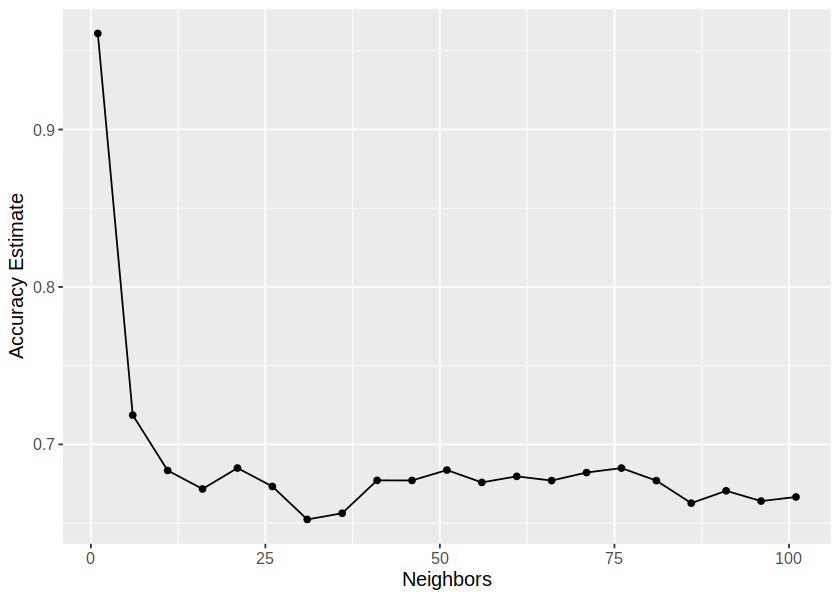

In [7]:
options(repr.plot.width = 7, repr.plot.height = 5)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 12))

accuracy_vs_k

In [8]:
best_k <- accuracies |>
          arrange(desc(mean)) |>
          slice(1) |>
          select(neighbors)

best_k

neighbors
<dbl>
1


In [9]:
heart_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
      set_engine("kknn") |>
      set_mode("classification")

heart_fit2 <- workflow() |>
      add_recipe(heart_recipe) |>
      add_model(heart_spec2) |>
      fit(data = heart_training)

heart_predictions <- predict(heart_fit2, heart_testing) |>
bind_cols(heart_testing)

heart_metrics <- heart_predictions |>
metrics(truth = target, estimate = .pred_class)

heart_conf_mat <- heart_predictions |> 
conf_mat(truth = target, estimate = .pred_class)

heart_predictions
heart_metrics
heart_conf_mat

.pred_class,age,trestbps,thalach,target
<fct>,<dbl>,<dbl>,<dbl>,<fct>
Present,58,100,122,Present
Absent,54,122,116,Absent
Present,50,120,162,Present
Absent,60,140,155,Absent
Absent,61,145,146,Absent
Absent,56,130,142,Absent
Absent,55,180,117,Absent
Present,50,120,162,Present
Present,50,129,163,Present


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9883268
kap,binary,0.9766215


          Truth
Prediction Absent Present
   Absent     122       0
   Present      3     132

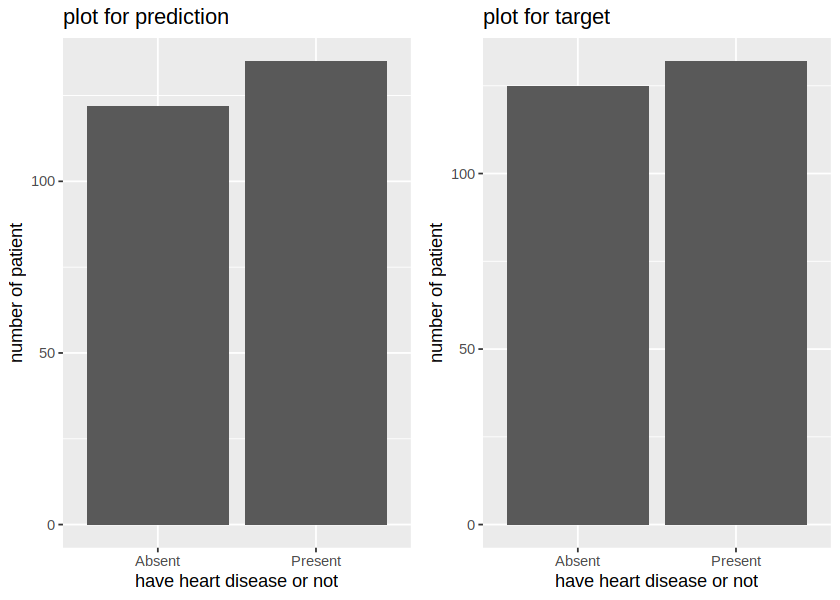

In [12]:
count_target <- heart_predictions |>
group_by(target) |>
summarize(count = n()) 

count_pred <- heart_predictions |>
group_by(.pred_class) |>
summarize(count = n()) 

heart_prediction_plot <- count_pred |>
ggplot(aes(x = .pred_class , y = count)) +
geom_bar(stat = "identity", position = "dodge") +
xlab("have heart disease or not") +
ylab("number of patient") +
ggtitle("plot for prediction")

heart_target_plot <- count_target |>
ggplot(aes(x = target , y = count)) +
geom_bar(stat = "identity", position = "dodge") +
xlab("have heart disease or not") +
ylab("number of patient") +
ggtitle("plot for target")

plot_grid(heart_prediction_plot, heart_target_plot, ncol = 2)

### Discussion


Our best model achieved an accuracy of 98.8%, with the predictors age, resting blood pressure, and the maximum heart rate achieved by the patient. During exploratory analysis, we determined that max heart rate had the strongest relationship to whether the patient had heart disease, the other two with a weaker relationship. We expected a better accuracy from a model using the chosen predictors versus a model that used all of the provided variables. Since some variables were numerically categorical and represented on different number scales. It was unclear to us, as non-medical professionals, how those numbers should affect the predictions. 

We created multiple models using combinations of the three predictors we had chosen, and the model with all 3 yielded the highest accuracy. We expected a strong relationship between the predictors we had chosen and whether the patient had heart disease or not. As human bodies age, older people are more susceptible to heart diseases due to weakened cardiac functions. External factors, such as illnesses, can further compromise the heart’s strength. 

From our discoveries, we may conclude that the factors under consideration significantly correlate with a patient’s condition. These findings may aid medical professionals in refining their diagnoses. In addition, the model could be used in medical research to generate predictions across a great population, rather than being restricted to the existing history of medical diagnoses. 

Moreover, by analyzing a dataset with other factors, we may determine other factors that are consistent across those who have heart disease. For example, if we were working with a similar dataset that provided information on the patients’ medical and family history, or dietary habits. We can see that certain individuals hold higher potentials of getting heart disease and offer preventive care. 

Further questions we have encountered are, is it possible to predict the severity of the patients’ heart disease based on the data? If so, can we classify the disease type as well? Similar methods of identifying disease could also be extended to other health complications. This can serve as a basis for a model which can identify all of an individual’s health risks.

Therefore, our model is a great resource for medical research and a supportive tool for medical diagnosis. Through further enhancements and research, it holds the potential to prevent disease before they manifest. 



### References

https://bmcpublichealth.biomedcentral.com/articles/10.1186/s12889-018-5653-9

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6616540/#:~:text=Age%20is%20a%20significant%20independent,obesity%20and%20diabetes%20%5B19%5D.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5059018/#:~:text=This%20study%20showed%20that%20SBPs,and%20expanded%2DCVD%20mortality%20risk.

Ruan, Y., Guo, Y., Zheng, Y., Huang, Z., Sun, S., Kowal, P., Shi, Y., &amp; Wu, F. (2018, June 20). Cardiovascular disease (CVD) and associated risk factors among older adults in six low-and middle-income countries: Results from sage wave 1 - BMC public health. BioMed Central. https://bmcpublichealth.biomedcentral.com/articles/10.1186/s12889-018-5653-9 

Centers for Disease Control and Prevention. (2022, September 8). Heart disease and stroke. Centers for Disease Control and Prevention. https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm 